In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [36]:
# Data cleaning
# EDA
# Text Preprocessing 
# Model Building
# Evalaution
# Improvement
# we will increase precision
# We need to reduce false positive as if the message is not spam it is considered spam 

In [1]:
import pandas as pd
import emoji
import re
import time
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from textblob import TextBlob
np.random.seed(20)
nltk.download('punkt')
exclude=string.punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**FUNCTIONS**

In [38]:
# def remove_emoji(text):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)
# def remove_html_text(text):
#     text = re.sub(r'<.*?>',' ',text)
#     text = re.sub(' +', ' ',text)
#     return text.strip().lower() 
# def remove_url(text):
#     pattern = re.compile(r'https?://\S+|www\.\S+')
#     return pattern.sub(r'', text)
# def remove_punc1(text):
#     return text.translate(str.maketrans('', '', exclude))
# import emoji
# print(emoji.demojize('Python is 😘'))
# def remove_stopwords(text):
#     new_text = []
    
#     for word in text.split():
#         if word in stopwords.words('english'):
#             new_text.append('')
#         else:
#             new_text.append(word)
#     x = new_text[:]
#     new_text.clear()
#     return " ".join(x)
# ps = PorterStemmer()

# def stem_words(text):
#     return " ".join([ps.stem(word) for word in text.split()])
# wordnet_lemmatizer = WordNetLemmatizer()

# sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
# punctuations="?:!.,;"
# sentence_words = nltk.word_tokenize(sentence)
# for word in sentence_words:
#     if word in punctuations:
#         sentence_words.remove(word)

# sentence_words
# print("{0:20}{1:20}".format("Word","Lemma"))
# for word in sentence_words:
#     print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word,pos='v')))


In [2]:
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding="latin-1",usecols=["v1","v2"])
df.rename(columns = {'v1':'Target','v2':'Text'}, inplace = True)


In [40]:
# df.isnull().sum()
# df.duplicated().sum() 
df=df.drop_duplicates(keep='first')

In [3]:
exclude=string.punctuation
df.shape
df['Target'].value_counts()

Target
ham     4825
spam     747
Name: count, dtype: int64

**EDA**

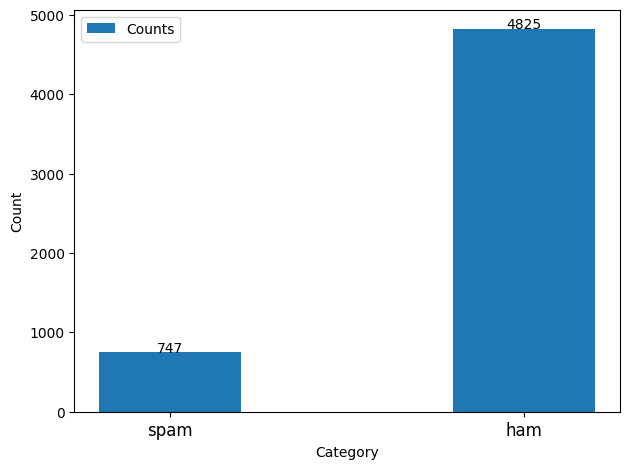

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

categories = ['spam', 'ham']

# Filter messages for spam and ham
count_spam = df[df['Target'] == 'spam']['Target'].value_counts()
count_ham = df[df['Target'] == 'ham']['Target'].value_counts()

bar_positions = [0, 1]

ax.bar(bar_positions, [count_spam.get('spam', 0), count_ham.get('ham', 0)], width=0.4, label='Counts')

ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories, fontsize=12)

for pos, value in zip(bar_positions, [count_spam.get('spam', 0), count_ham.get('ham', 0)]):
    plt.text(x=pos, y=value + 1, s=str(value), ha='center')

plt.legend()
plt.tight_layout()
plt.show()


In [5]:
df['Target']=df['Target'].map({'spam':1,'ham':0})
df.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['num_characters'] = df['Text'].apply(len)
df['num_words']=df['Text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sent']=df['Text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,Target,Text,num_characters,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [7]:
#Ham messages 
df[df['Target']==0][['num_words','num_characters','num_sent']].describe()

,num_words,num_characters,num_sent
count,4825.000000,4825.000000,4825.000000
mean,17.076062,71.023627,1.832332
std,13.875446,58.016023,1.431214
min,1.000000,2.000000,1.000000
25%,8.000000,33.000000,1.000000
50%,13.000000,52.000000,1.000000
75%,22.000000,92.000000,2.000000
max,219.000000,910.000000,38.000000


In [8]:
#Spam Messages 
df[df['Target']==1][['num_words','num_characters','num_sent']].describe()

,num_words,num_characters,num_sent
count,747.000000,747.000000,747.000000
mean,27.706827,138.866131,3.020080
std,6.768560,29.183082,1.538034
min,2.000000,13.000000,1.000000
25%,25.000000,132.500000,2.000000
50%,29.000000,149.000000,3.000000
75%,32.000000,157.000000,4.000000
max,44.000000,224.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

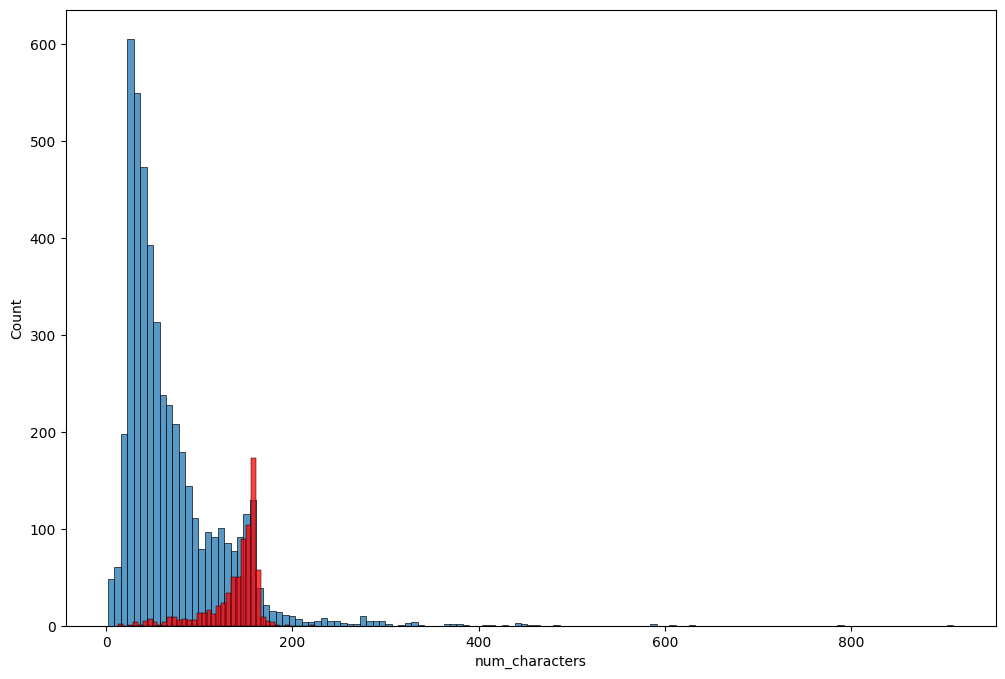

In [9]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['Target'] == 0]['num_characters'])
sns.histplot(df[df['Target'] == 1]['num_characters'],color='red')

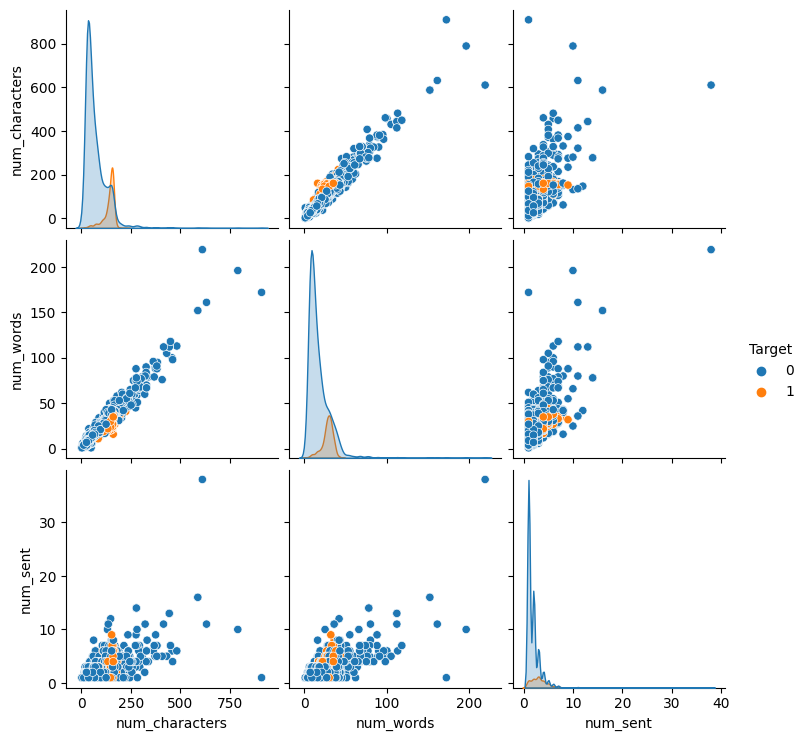

In [10]:
df1 = df.drop(columns='Text')
sns.pairplot(df,hue='Target')

<Axes: >

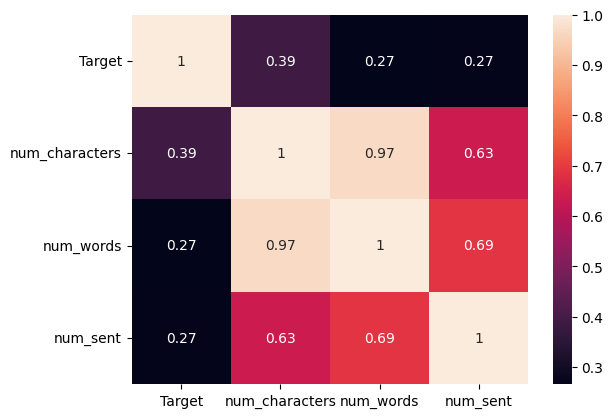

In [11]:
sns.heatmap(df1.corr(),annot=True)
# As coorelation between Target and num_characters is high so we will keep it and remove others

**FUNCTIONS**

In [12]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [17]:
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import re
def transform_text1(text):
    text = text.lower()
#     text = re.sub(r'<.*?>', ' ', text)
#     text = re.sub(' +', ' ', text)
#     text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
#     text = text.translate(str.maketrans('', '', exclude))
#     text_corrector = TextBlob(text)
#     text_corrected = text_corrector.correct().string
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum() and i not in stopwords.words('english') and i not in exclude:
            y.append(ps.stem(i))
    return " ".join(y)


# text_example = "This is an example sentence. It may contain some <html> tags and https://example.com links."
# transform_text(text_example)

    

In [18]:
df['processed']=df['Text'].apply(transform_text1)

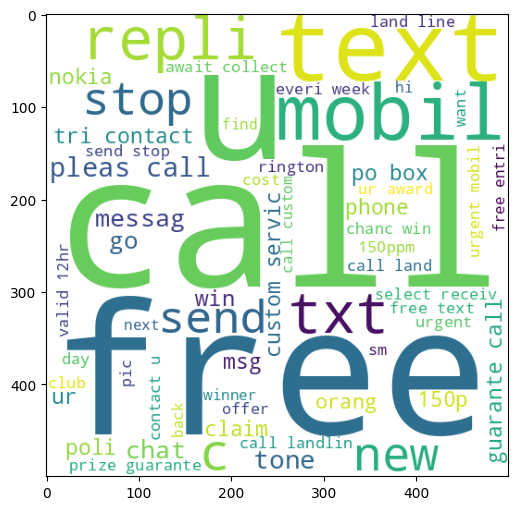

In [19]:
# Maximum of words in spam messages 
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=15,background_color='white')
spam_wc = wc.generate(df[df['Target'] == 1]['processed'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

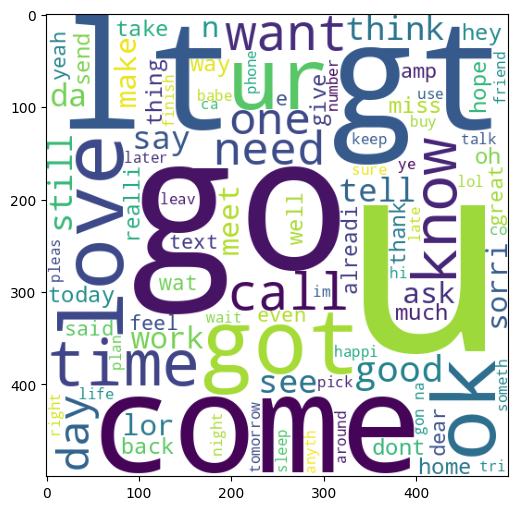

In [20]:
# Maximum of words in ham messages 
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=15,background_color='white')
ham_wc = wc.generate(df[df['Target'] == 0]['processed'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [22]:
df.head()

,Target,Text,num_characters,num_words,num_sent,processed
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [ ]:
spam_corpus = []
for msg in df[df['Target'] == 1]['processed'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
spam_corpus

In [25]:
df.head()

,Target,Text,num_characters,num_words,num_sent,processed
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


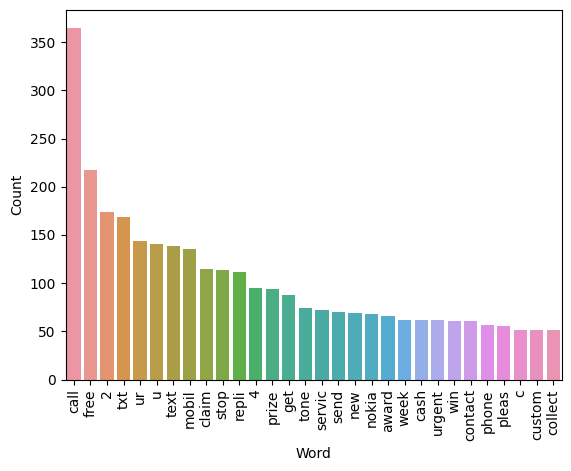

In [26]:
from collections import Counter
counter = Counter(spam_corpus)
common_items_df = pd.DataFrame(counter.most_common(30), columns=['Word', 'Count'])
sns.barplot(x='Word', y='Count', data=common_items_df)
plt.xticks(rotation='vertical')
plt.show()

In [27]:
common_items_df

,Word,Count
0,call,365
1,free,217
2,2,174
3,txt,169
4,ur,144
5,u,141
6,text,139
7,mobil,135
8,claim,115
9,stop,114


In [28]:
df

,Target,Text,num_characters,num_words,num_sent,processed
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


**Model Selection**

In [71]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=4000)


In [72]:
X = tfidf.fit_transform(df['processed'])
X=X.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
y=df['Target']
y.values

array([0, 0, 1, ..., 0, 0, 0])

In [74]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [75]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [76]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(classification_report(y_test, y_pred1))
print(precision_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       957
           1       0.52      0.80      0.63       158

    accuracy                           0.87      1115
   macro avg       0.74      0.84      0.77      1115
weighted avg       0.90      0.87      0.88      1115

0.5206611570247934


In [77]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)

print(classification_report(y_test, y_pred2))
print(precision_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       957
           1       0.99      0.75      0.85       158

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.96      0.96      0.96      1115

0.9915966386554622


In [78]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)

print(classification_report(y_test, y_pred3))
print(precision_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       957
           1       0.98      0.82      0.89       158

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

0.9847328244274809


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [80]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [81]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [82]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)


For  SVC
Accuracy -  0.9713004484304932
Precision -  0.9772727272727273
For  KN
Accuracy -  0.9040358744394619
Precision -  1.0
For  NB
Accuracy -  0.9632286995515695
Precision -  0.9915966386554622
For  DT
Accuracy -  0.9210762331838565
Precision -  0.8723404255319149
For  LR
Accuracy -  0.9479820627802691
Precision -  0.9545454545454546
For  RF
Accuracy -  0.9641255605381166
Precision -  1.0
For  AdaBoost
Accuracy -  0.9596412556053812
Precision -  0.924812030075188
For  BgC
Accuracy -  0.9614349775784753
Precision -  0.9389312977099237
For  ETC
Accuracy -  0.9713004484304932
Precision -  1.0
For  GBDT
Accuracy -  0.9354260089686098
Precision -  0.93
For  xgb
Accuracy -  0.9641255605381166
Precision -  0.9758064516129032


In [83]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df


,Algorithm,Accuracy,Precision
1,KN,0.904036,1.000000
5,RF,0.964126,1.000000
8,ETC,0.971300,1.000000
2,NB,0.963229,0.991597
0,SVC,0.971300,0.977273
10,xgb,0.964126,0.975806
4,LR,0.947982,0.954545
7,BgC,0.961435,0.938931
9,GBDT,0.935426,0.930000
6,AdaBoost,0.959641,0.924812


In [84]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.904036
1,RF,Accuracy,0.964126
2,ETC,Accuracy,0.971300
3,NB,Accuracy,0.963229
4,SVC,Accuracy,0.971300
5,xgb,Accuracy,0.964126
6,LR,Accuracy,0.947982
7,BgC,Accuracy,0.961435
8,GBDT,Accuracy,0.935426
9,AdaBoost,Accuracy,0.959641


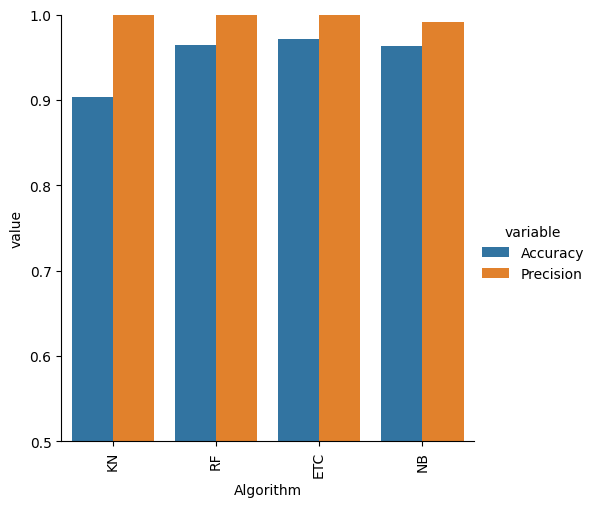

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of specific algorithms you want to include
selected_algorithms = ['ETC', 'RF', 'NB','KN']

# Filter the DataFrame based on the selected algorithms
filtered_df = performance_df1[performance_df1['Algorithm'].isin(selected_algorithms)]

# Plot the catplot using the filtered DataFrame
sns.catplot(x='Algorithm', y='value', hue='variable', data=filtered_df, kind='bar', height=5)
plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
# As you can see Extra Tree Claassifier is performing good because precision and accuracy is maximum from other


In [92]:
knc = KNeighborsClassifier()
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('KN', knc), ('RF', rfc), ('ET', etc)],voting='soft')
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('KN', KNeighborsClassifier()),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2)),
                             ('ET',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [94]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))


Accuracy 0.9497757847533632
Precision 1.0


In [ ]:
#Voting Not prefred Because Accuracy not increased  